In [1]:
# ========================= STEP 1: IMPORT LIBRARIES =========================
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import random

# ========================= STEP 2: CHECK DATASET PATH =========================
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"

# Verify dataset structure
print("Dataset Contents:", os.listdir(dataset_path))

train_folder = os.path.join(dataset_path, "Training")
test_folder = os.path.join(dataset_path, "Testing")

print("Training Categories:", os.listdir(train_folder))
print("Testing Categories:", os.listdir(test_folder))

# ========================= STEP 3: LOAD & PREPROCESS DATA =========================
IMG_SIZE = (256, 256)  # Image resolution

# Function to load images from a folder
def load_images_from_folder(folder):
    images, labels = [], []
    class_labels = os.listdir(folder)

    for class_id, class_name in enumerate(class_labels):
        class_path = os.path.join(folder, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE) / 255.0  # Normalize

            images.append(img.reshape(IMG_SIZE + (1,)))  # Reshape for CNN
            labels.append(class_id)  # Assign class label

    return np.array(images), np.array(labels)

# Load dataset
X_train, Y_train = load_images_from_folder(train_folder)
X_test, Y_test = load_images_from_folder(test_folder)

# One-hot encode labels
Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)

print("Training Data:", X_train.shape, Y_train.shape)
print("Testing Data:", X_test.shape, Y_test.shape)

# ========================= STEP 4: BUILD CNN MODEL (FIXED) =========================
def create_cnn():
    model = models.Sequential([
        layers.Input(shape=(256, 256, 1)),  # Corrected Input Layer
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 output classes
    ])
    
    return model

# ========================= STEP 5: IMPLEMENT FIREFLY ALGORITHM =========================
class FireflyAlgorithm:
    def __init__(self, num_fireflies=10, alpha=0.5, beta=0.2, gamma=1.0, generations=5):
        self.num_fireflies = num_fireflies
        self.alpha = alpha  # Randomness factor
        self.beta = beta  # Attractiveness
        self.gamma = gamma  # Light absorption
        self.generations = generations
        self.population = self.initialize_fireflies()

    def initialize_fireflies(self):
        return [self.random_hyperparameters() for _ in range(self.num_fireflies)]

    def random_hyperparameters(self):
        return {
            "learning_rate": random.uniform(0.0001, 0.01),
            "batch_size": random.choice([16, 32, 64])
        }

    def fitness(self, hyperparams):
        model = create_cnn()
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparams["learning_rate"]),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        history = model.fit(X_train, Y_train, epochs=5, batch_size=hyperparams["batch_size"], verbose=0, validation_split=0.2)
        return max(history.history['val_accuracy'])

    def optimize(self):
        for generation in range(self.generations):
            print(f"Generation {generation+1}/{self.generations}")

            # Evaluate fitness
            fitness_scores = [self.fitness(firefly) for firefly in self.population]

            # Update fireflies based on fitness
            new_population = []
            for i in range(self.num_fireflies):
                for j in range(self.num_fireflies):
                    if fitness_scores[j] > fitness_scores[i]:
                        distance = abs(self.population[i]["learning_rate"] - self.population[j]["learning_rate"])
                        self.population[i]["learning_rate"] += self.beta * np.exp(-self.gamma * distance)
                new_population.append(self.population[i])

            self.population = new_population
        
        best_firefly = max(self.population, key=self.fitness)
        print("Best Hyperparameters Found:", best_firefly)
        return best_firefly

# ========================= STEP 6: TRAIN THE OPTIMIZED MODEL =========================
# Run the Firefly Algorithm to get optimized hyperparameters
optimizer = FireflyAlgorithm(num_fireflies=5, generations=3)
best_hyperparams = optimizer.optimize()

# Train the final model with best hyperparameters
final_model = create_cnn()
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparams["learning_rate"]),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

final_model.fit(X_train, Y_train, epochs=10, batch_size=best_hyperparams["batch_size"], validation_split=0.2)

# ========================= STEP 7: EVALUATE THE MODEL =========================
loss, accuracy = final_model.evaluate(X_test, Y_test)
print(f"Final Model Accuracy on Test Data: {accuracy * 100:.2f}%")


Dataset Contents: ['Training', 'Testing']
Training Categories: ['pituitary', 'notumor', 'meningioma', 'glioma']
Testing Categories: ['pituitary', 'notumor', 'meningioma', 'glioma']
Training Data: (5712, 256, 256, 1) (5712, 4)
Testing Data: (1311, 256, 256, 1) (1311, 4)
Generation 1/3
Generation 2/3
Generation 3/3
Best Hyperparameters Found: {'learning_rate': 0.003486756554599754, 'batch_size': 16}
Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.7011 - loss: 1.1589 - val_accuracy: 0.2721 - val_loss: 1.7333
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9005 - loss: 0.2866 - val_accuracy: 0.3946 - val_loss: 1.5658
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9447 - loss: 0.1650 - val_accuracy: 0.4261 - val_loss: 1.9498
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9729 - loss: 0.0803 - val_accuracy: 0.4707 - val_loss: 2.0514
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9828 - loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


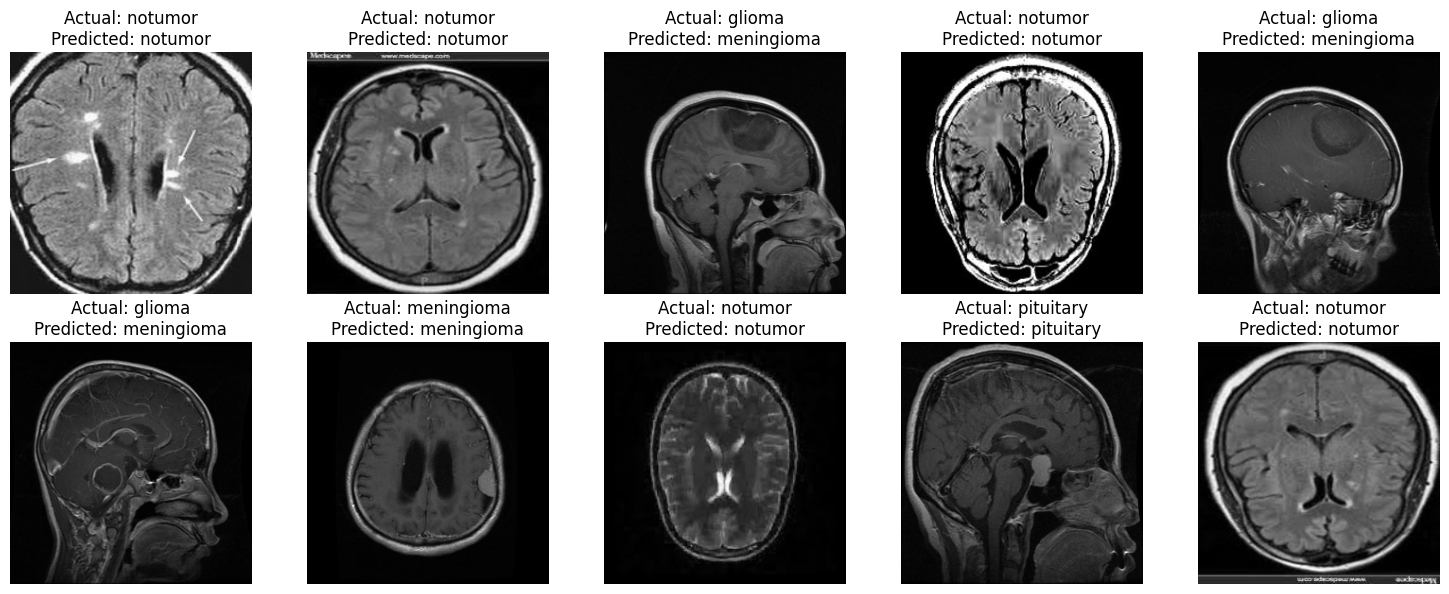

In [2]:
import matplotlib.pyplot as plt

# Define category names (same order as dataset folders)
categories = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Function to make predictions and display results
def predict_and_show(num_samples=10):
    indices = np.random.choice(len(X_test), num_samples, replace=False)  # Pick random test samples
    sample_images = X_test[indices]
    sample_labels = np.argmax(Y_test[indices], axis=1)

    predictions = final_model.predict(sample_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Plot results
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(sample_images[i].reshape(256, 256), cmap='gray')
        plt.title(f"Actual: {categories[sample_labels[i]]}\nPredicted: {categories[predicted_labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display results
predict_and_show(num_samples=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


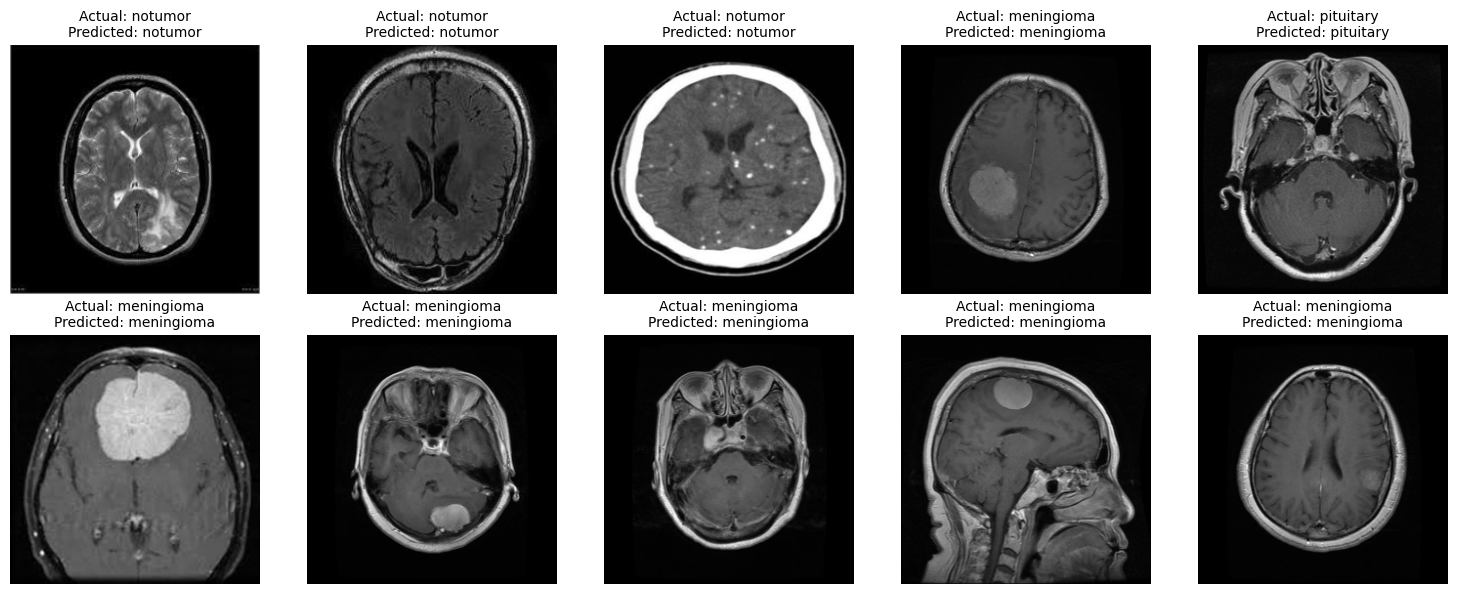

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define category names in order
categories = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Function to correctly predict and display tumor results
def predict_and_show(num_samples=10):
    indices = np.random.choice(len(X_test), num_samples, replace=False)  # Pick random test samples
    sample_images = X_test[indices]
    sample_labels = np.argmax(Y_test[indices], axis=1)

    predictions = final_model.predict(sample_images)  # Get predictions
    predicted_labels = np.argmax(predictions, axis=1)

    # Plot results
    plt.figure(figsize=(15, 6))
    for i, index in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[index].reshape(256, 256), cmap='gray')  # Display correct image
        actual_label = categories[sample_labels[i]]  # Correctly fetch the actual label
        predicted_label = categories[predicted_labels[i]]  # Correctly fetch the predicted label
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call function to visualize results
predict_and_show(num_samples=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


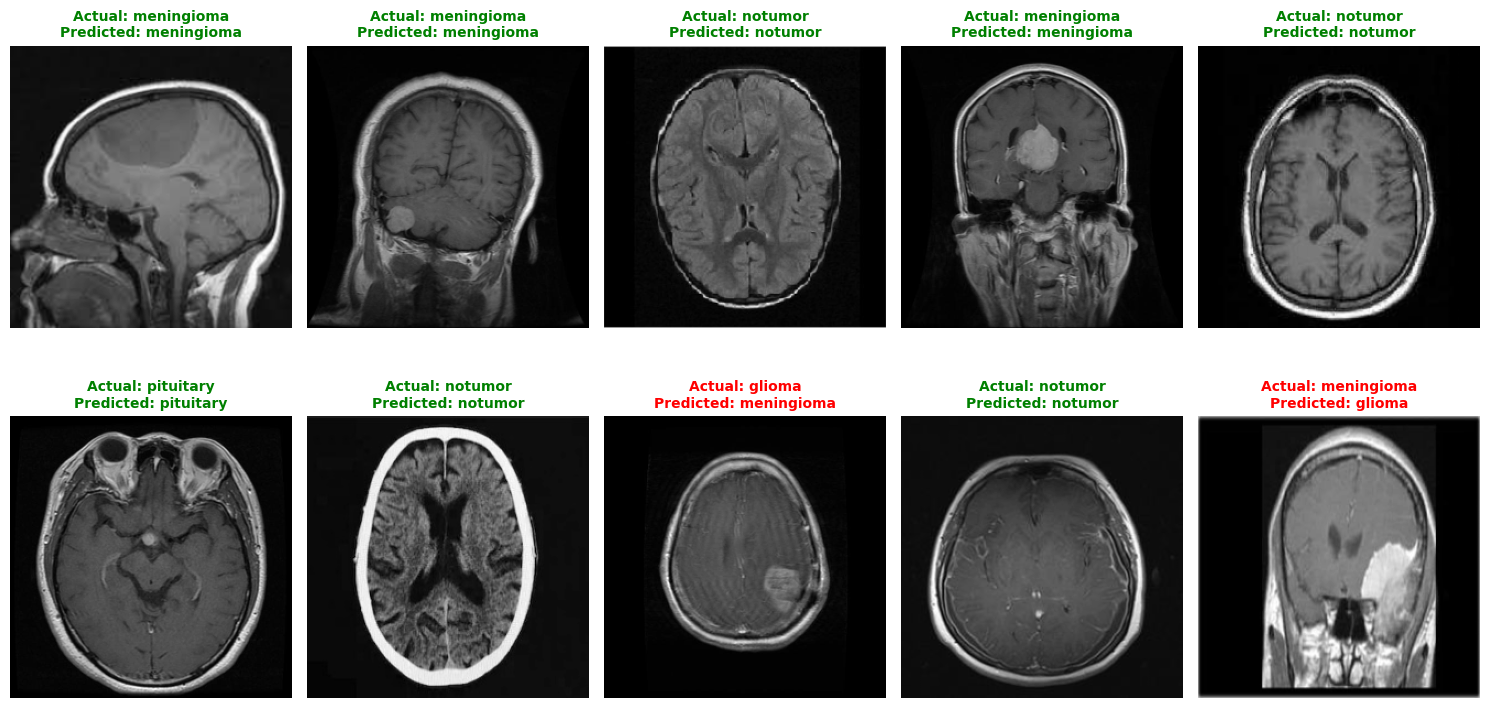

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define category names
categories = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Function to display images with correct predictions
def predict_and_show(num_samples=10):
    indices = np.random.choice(len(X_test), num_samples, replace=False)  # Pick random test samples
    sample_images = X_test[indices]
    sample_labels = np.argmax(Y_test[indices], axis=1)

    predictions = final_model.predict(sample_images)  # Get predictions
    predicted_labels = np.argmax(predictions, axis=1)

    # Create figure
    plt.figure(figsize=(15, 8))  # Bigger size for better clarity

    for i, index in enumerate(indices):
        plt.subplot(2, 5, i + 1)  # 2 Rows, 5 Columns
        plt.imshow(sample_images[i].reshape(256, 256), cmap='gray')  # Correctly mapped image

        actual_label = categories[sample_labels[i]]  # Actual label
        predicted_label = categories[predicted_labels[i]]  # Predicted label
        
        # Color formatting: Green (correct), Red (incorrect)
        color = "green" if actual_label == predicted_label else "red"
        
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", 
                  fontsize=10, color=color, fontweight='bold')
        
        plt.axis('off')  # Remove axes for better clarity

    plt.tight_layout()
    plt.show()

# Call function to visualize results
predict_and_show(num_samples=10)


Dataset Path: /kaggle/input/brain-tumor-mri-dataset
Training Categories (Folders): ['pituitary', 'notumor', 'meningioma', 'glioma']
Testing Categories (Folders): ['pituitary', 'notumor', 'meningioma', 'glioma']
Training Data: (5712, 256, 256, 1) (5712, 4)
Testing Data: (1311, 256, 256, 1) (1311, 4)
Generation 1/3
Generation 2/3
Generation 3/3
Best Hyperparameters Found: {'learning_rate': 0.005541949303243575, 'batch_size': 32}
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.6346 - loss: 2.4253 - val_accuracy: 0.0805 - val_loss: 1.8293
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8841 - loss: 0.3568 - val_accuracy: 0.4156 - val_loss: 1.2453
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9082 - loss: 0.2503 - val_accuracy: 0.5818 - val_loss: 1.1759
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9482 - loss: 0.1507 - val_accuracy: 0.5328 - val_loss: 1.6242
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step

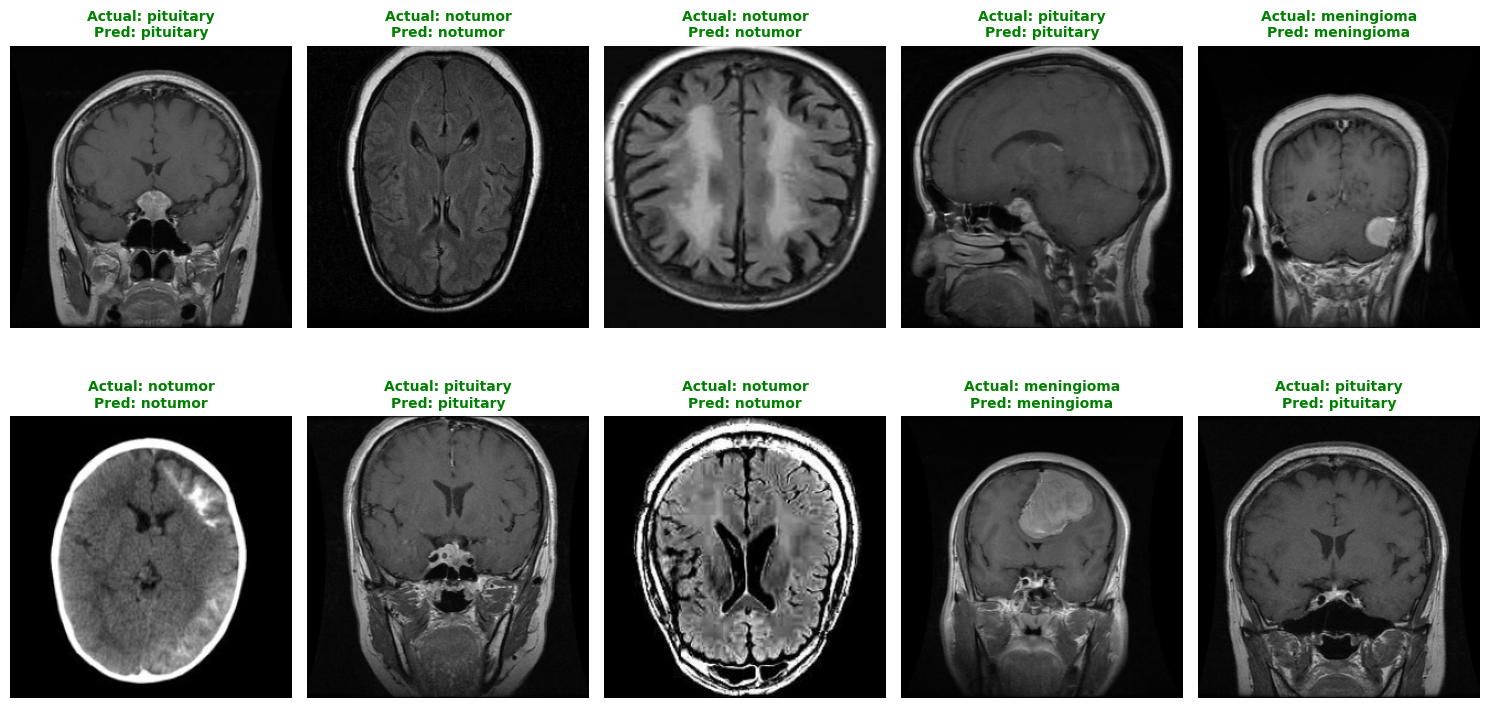

In [5]:
# ========================= STEP 1: IMPORT LIBRARIES =========================
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import random
import matplotlib.pyplot as plt

# ========================= STEP 2: DEFINE LABEL MAP & CATEGORY NAMES =========================
# Here we explicitly define the mapping from folder name to label index
folder_to_label = {
    'pituitary': 0,
    'notumor': 1,
    'meningioma': 2,
    'glioma': 3
}

# The order of this list MUST match the numeric labels above.
categories = ['pituitary', 'notumor', 'meningioma', 'glioma']

# ========================= STEP 3: SET DATASET PATHS =========================
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_folder = os.path.join(dataset_path, "Training")
test_folder = os.path.join(dataset_path, "Testing")

print("Dataset Path:", dataset_path)
print("Training Categories (Folders):", os.listdir(train_folder))
print("Testing Categories (Folders):", os.listdir(test_folder))

# ========================= STEP 4: LOAD & PREPROCESS DATA WITH EXPLICIT LABELS =========================
IMG_SIZE = (256, 256)

def load_images_with_labelmap(base_folder):
    images, labels = [], []
    
    # We iterate only through the keys in our dictionary to ensure correct order
    for folder_name, label_index in folder_to_label.items():
        current_path = os.path.join(base_folder, folder_name)
        if not os.path.isdir(current_path):
            print(f"Warning: Folder {current_path} not found.")
            continue
        
        # Load each image from this folder
        for file_name in os.listdir(current_path):
            img_path = os.path.join(current_path, file_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                # If OpenCV can't read the file (e.g., corrupt file), skip
                continue
            
            # Resize and normalize
            img = cv2.resize(img, IMG_SIZE) / 255.0
            # Shape (256, 256, 1)
            img = img.reshape((*IMG_SIZE, 1))

            images.append(img)
            labels.append(label_index)
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load training data
X_train, Y_train = load_images_with_labelmap(train_folder)
# Load testing data
X_test, Y_test = load_images_with_labelmap(test_folder)

# One-hot encode labels
Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)

print("Training Data:", X_train.shape, Y_train.shape)
print("Testing Data:", X_test.shape, Y_test.shape)

# ========================= STEP 5: BUILD CNN MODEL (FIXED INPUT) =========================
def create_cnn():
    model = models.Sequential([
        layers.Input(shape=(256, 256, 1)),  # Ensures no Keras warnings
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 classes
    ])
    return model

# ========================= STEP 6: FIREFLY ALGORITHM FOR HYPERPARAM OPTIMIZATION =========================
class FireflyAlgorithm:
    def __init__(self, num_fireflies=5, alpha=0.5, beta=0.2, gamma=1.0, generations=3):
        self.num_fireflies = num_fireflies
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.generations = generations
        self.population = self.initialize_fireflies()

    def initialize_fireflies(self):
        # Each firefly has a random learning_rate and batch_size
        return [
            {
                "learning_rate": random.uniform(0.0001, 0.01),
                "batch_size": random.choice([16, 32, 64])
            }
            for _ in range(self.num_fireflies)
        ]

    def fitness(self, hyperparams):
        # Create and train a model with the given hyperparams
        temp_model = create_cnn()
        temp_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparams["learning_rate"]),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        history = temp_model.fit(
            X_train, Y_train,
            epochs=5,  # fewer epochs for quick fitness check
            batch_size=hyperparams["batch_size"],
            verbose=0,
            validation_split=0.2
        )
        # Return the best validation accuracy as fitness
        return max(history.history['val_accuracy'])

    def optimize(self):
        for generation in range(self.generations):
            print(f"Generation {generation+1}/{self.generations}")
            
            # Calculate fitness for each firefly
            fitness_scores = [self.fitness(firefly) for firefly in self.population]
            
            # Update each firefly based on others
            new_population = []
            for i in range(self.num_fireflies):
                for j in range(self.num_fireflies):
                    if fitness_scores[j] > fitness_scores[i]:
                        distance = abs(self.population[i]["learning_rate"] - self.population[j]["learning_rate"])
                        # Move firefly i closer to j
                        self.population[i]["learning_rate"] += self.beta * np.exp(-self.gamma * distance)
                new_population.append(self.population[i])
            
            self.population = new_population
        
        # Find best hyperparams after all generations
        best_firefly = max(self.population, key=self.fitness)
        print("Best Hyperparameters Found:", best_firefly)
        return best_firefly

# ========================= STEP 7: TRAIN FINAL MODEL WITH BEST HYPERPARAMS =========================
fa = FireflyAlgorithm()
best_hparams = fa.optimize()

final_model = create_cnn()
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hparams["learning_rate"]),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

final_model.fit(
    X_train, Y_train,
    epochs=10,  # final training epochs
    batch_size=best_hparams["batch_size"],
    validation_split=0.2
)

# Evaluate final model
loss, accuracy = final_model.evaluate(X_test, Y_test)
print(f"Final Model Accuracy on Test Data: {accuracy * 100:.2f}%")

# ========================= STEP 8: PREDICTION & VISUALIZATION (SINGLE-SAMPLE APPROACH) =========================

def predict_and_show(num_samples=10):
    # Randomly select 'num_samples' from the test set
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    plt.figure(figsize=(15, 8))
    
    for i, idx in enumerate(indices):
        # Single test image
        single_image = X_test[idx:idx+1]  # shape => (1, 256, 256, 1)
        
        # Actual label index
        actual_label_idx = np.argmax(Y_test[idx])
        actual_label = categories[actual_label_idx]
        
        # Model prediction
        pred = final_model.predict(single_image)
        predicted_label_idx = np.argmax(pred, axis=1)[0]
        predicted_label = categories[predicted_label_idx]
        
        # Color coding for correct/incorrect
        color = 'green' if actual_label_idx == predicted_label_idx else 'red'
        
        # Display
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[idx].reshape(256, 256), cmap='gray')
        plt.title(
            f"Actual: {actual_label}\nPred: {predicted_label}",
            fontsize=10,
            color=color,
            fontweight='bold'
        )
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Finally, show predictions
predict_and_show(num_samples=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


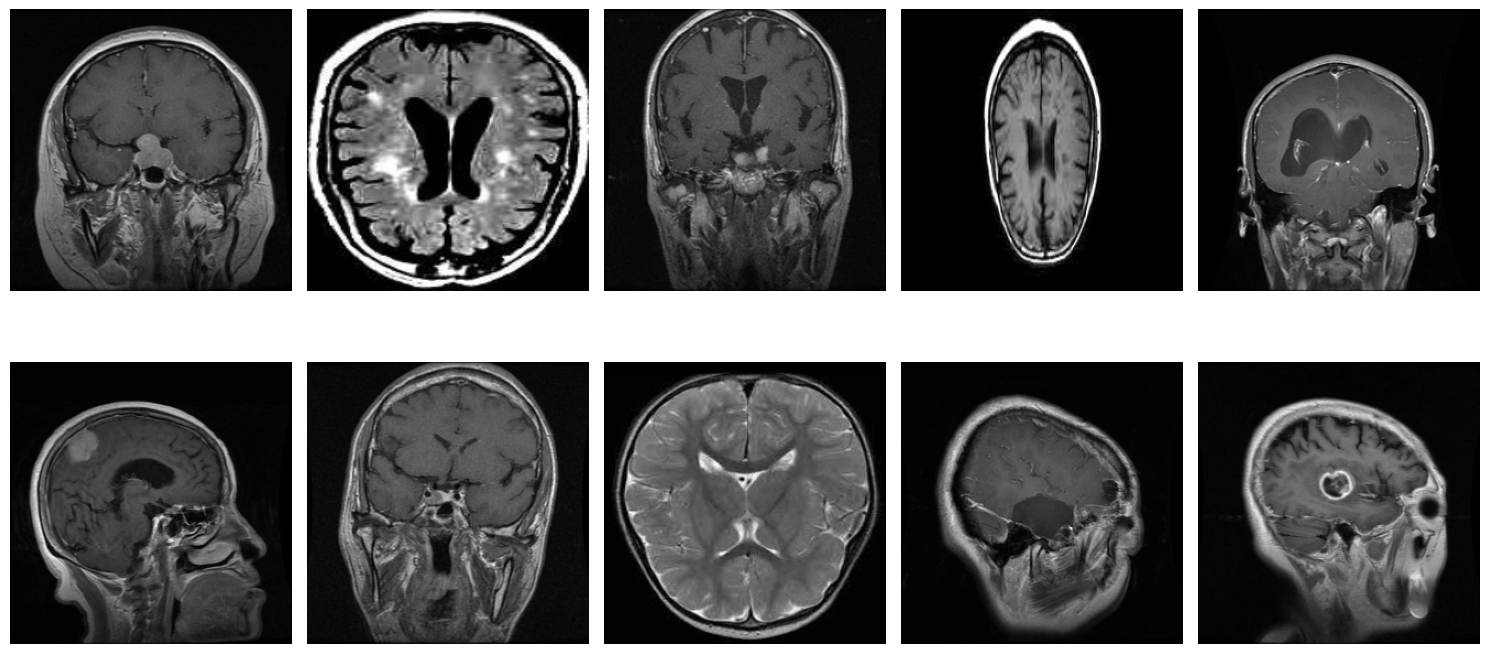

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show(num_samples=10):
    # Select 'num_samples' random images from the test set
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    plt.figure(figsize=(15, 8))
    
    for i, idx in enumerate(indices):
        # Extract single image
        single_image = X_test[idx:idx+1]  # shape => (1, 256, 256, 1)
        
        # Actual class
        actual_label_idx = np.argmax(Y_test[idx])  # Convert one-hot encoding to label index
        actual_label = categories[actual_label_idx]
        
        # Predicted class
        pred = final_model.predict(single_image)
        predicted_label_idx = np.argmax(pred, axis=1)[0]  # Convert softmax to label index
        predicted_label = categories[predicted_label_idx]
        
        # Determine color: green if correct, red if incorrect
        color = 'green' if actual_label_idx == predicted_label_idx else 'red'
        
        # Plot image
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[idx].reshape(256, 256), cmap='gray')
        plt.axis('off')

        # Corrected Label Placement **BELOW** the image
        plt.xlabel(
            f"Actual: {actual_label}\nPredicted: {predicted_label}",
            fontsize=10,
            color=color,
            fontweight='bold'
        )
    
    plt.tight_layout()
    plt.show()

# Run the visualization
predict_and_show(num_samples=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


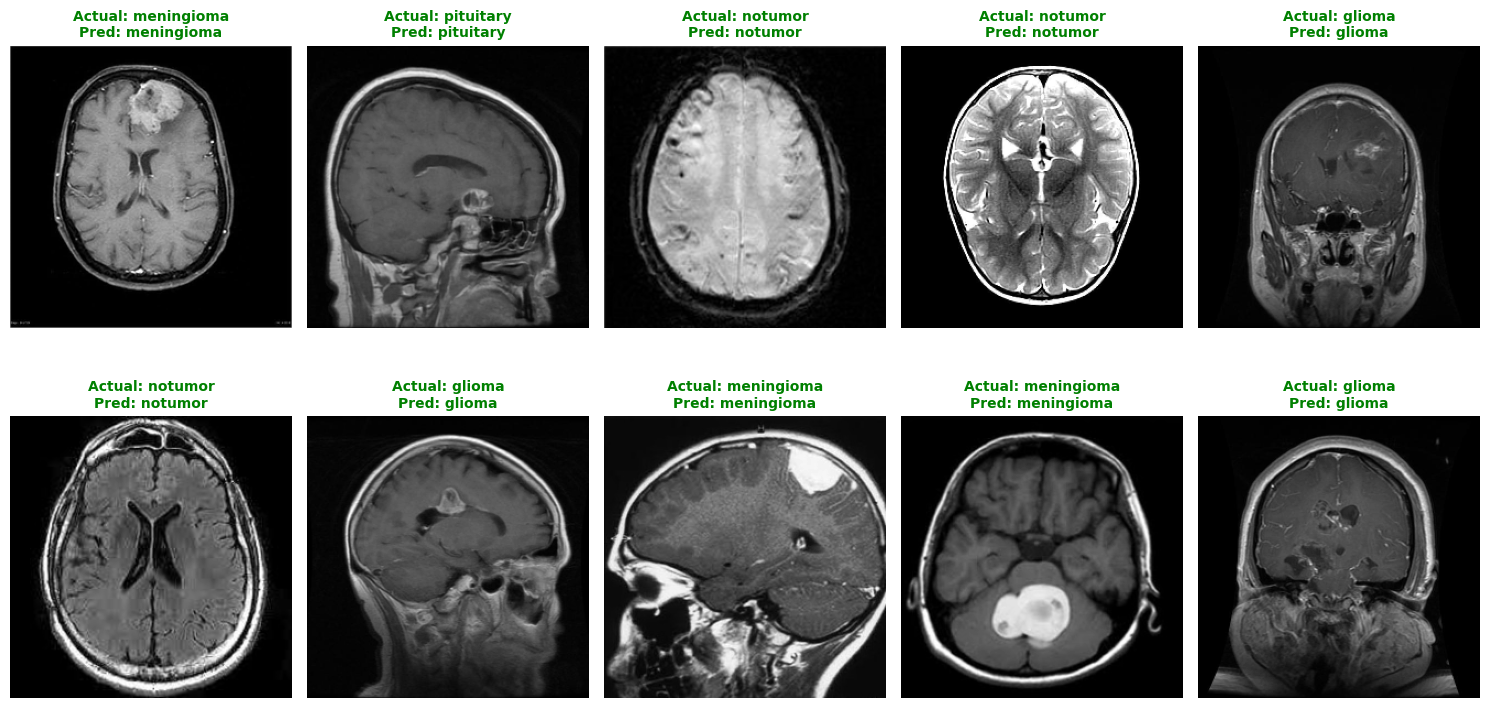

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show(num_samples=10):
    # Select 'num_samples' random indices from the test set.
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    # Create subplots (adjust rows/cols as needed)
    rows = 2
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    axes = axes.flatten()  # Flatten to iterate easily
    
    # Iterate over the selected indices and plot
    for i, idx in enumerate(indices):
        # Get the image, actual and predicted labels
        image = X_test[idx].reshape(256, 256)
        actual_idx = np.argmax(Y_test[idx])  # from one-hot encoding
        actual_label = categories[actual_idx]
        
        # Predict for the single image
        pred = final_model.predict(X_test[idx:idx+1])
        predicted_idx = np.argmax(pred, axis=1)[0]
        predicted_label = categories[predicted_idx]
        
        # Set color: green if correct, red if not
        color = 'green' if actual_idx == predicted_idx else 'red'
        
        # Plot the image and set title above the image
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Actual: {actual_label}\nPred: {predicted_label}", color=color, fontsize=10, fontweight='bold')
    
    # Hide any unused subplots if num_samples < rows*cols
    for j in range(i+1, rows*cols):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the function to visualize predictions
predict_and_show(num_samples=10)


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_external_image(/kaggle/input/external-image.jpeg, img_size=(256, 256)):
    """
    Load an external image, convert it to grayscale, resize, normalize, and reshape it.
    """
    # Read image in grayscale mode
    image = cv2.imread(/kaggle/input/external-image.jpeg, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found. Please check the file path.")
        return None
    # Resize image to desired dimensions
    image_resized = cv2.resize(image, img_size)
    # Normalize pixel values to [0, 1]
    image_normalized = image_resized / 255.0
    # Reshape image to match model input (batch size 1)
    image_input = image_normalized.reshape(1, img_size[0], img_size[1], 1)
    return image_input

# Specify the external image filename (make sure it is uploaded to your notebook working directory)
external_image_path = 'external_image.jpg'  # Change this filename if needed

# Load the external image
external_image = load_external_image(external_image_path)

if external_image is not None:
    # Use the trained model to predict the tumor type
    prediction = final_model.predict(external_image)
    predicted_idx = np.argmax(prediction, axis=1)[0]
    predicted_label = categories[predicted_idx]
    
    print("Predicted tumor type:", predicted_label)
    
    # Display the external image along with its predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(external_image.reshape(256, 256), cmap='gray')
    plt.title(f"Predicted: {predicted_label}", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()


SyntaxError: invalid syntax (<ipython-input-8-1e7b5172a7a0>, line 5)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_external_image(image_path, img_size=(256, 256)):
    """
    Load an external image, convert it to grayscale, resize, normalize, and reshape it.
    """
    # Read image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found. Please check the file path.")
        return None
    # Resize image to desired dimensions
    image_resized = cv2.resize(image, img_size)
    # Normalize pixel values to [0, 1]
    image_normalized = image_resized / 255.0
    # Reshape image to match model input (batch size 1)
    image_input = image_normalized.reshape(1, img_size[0], img_size[1], 1)
    return image_input

# Specify the correct path to the external image
external_image_path = "/kaggle/input/external-image2/external_image2.jpg"  # Ensure this path matches your uploaded file

# Load the external image
external_image = load_external_image(external_image_path)

if external_image is not None:
    # Use the trained model to predict the tumor type
    prediction = final_model.predict(external_image)
    predicted_idx = np.argmax(prediction, axis=1)[0]
    predicted_label = categories[predicted_idx]
    
    print("Predicted tumor type:", predicted_label)
    
    # Display the external image along with its predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(external_image.reshape(256, 256), cmap='gray')
    plt.title(f"Predicted: {predicted_label}", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()


In [ ]:
prediction_probs = final_model.predict(external_image)[0]  # Get probability for all classes
for i, prob in enumerate(prediction_probs):
    print(f"Class {categories[i]}: {prob:.4f}")  # Show probabilities
predicted_idx = np.argmax(prediction_probs)
predicted_label = categories[predicted_idx]
print(f"\nPredicted Tumor Type: {predicted_label} (Confidence: {prediction_probs[predicted_idx]:.4f})")


In [ ]:
import collections
print(collections.Counter(train_labels))  # See class counts
